# Module assignment: From Text to Network with LLMs

# Enviroment Setup

In [39]:
# --- ENV + sanity ---
from dotenv import load_dotenv
load_dotenv(override=True)

import os, sys
os.makedirs("outputs", exist_ok=True)

print("Kernel:", sys.executable)
print("GOOGLE_API_KEY set?", os.getenv("GOOGLE_API_KEY") is not None)

# Use a model you have access to
os.environ.setdefault("LLM_MODEL", "models/gemini-2.5-flash")
print("LLM model:", os.getenv("LLM_MODEL"))

print("outputs/ ready.")



Kernel: /Users/nielsandersen/Desktop/Natural_Language_Processing_and_Nework_Analysis/eksamen/.venv/bin/python
GOOGLE_API_KEY set? True
LLM model: models/gemini-2.5-flash
outputs/ ready.


In [25]:
import os, google.generativeai as genai
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
m = genai.GenerativeModel(os.getenv("LLM_MODEL"),
                          generation_config={"response_mime_type":"application/json","temperature":0})
r = m.generate_content('{"ping":"pong"}')
print("LLM OK:", r.text.strip())


LLM OK: {
  "ping": "pong"
}


In [ ]:
import sys, os
print(sys.executable)  
print(os.getenv("GOOGLE_API_KEY") is not None)  


/Users/nielsandersen/Desktop/Natural_Language_Processing_and_Nework_Analysis/eksamen/.venv/bin/python
True


## 1) Opsætning (pakker og miljø)

In [40]:
import os, json, re, random, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

# Environment (Gemini only)
os.environ.setdefault("LLM_PROVIDER", "google")
os.environ.setdefault("LLM_MODEL", "models/gemini-2.5-flash")
LLM_MODEL = os.getenv("LLM_MODEL", "models/gemini-2.5-flash")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
assert GOOGLE_API_KEY, "Set GOOGLE_API_KEY as an environment variable (.env or environment)."

RANDOM_SEED  = 42
SAMPLE_N     = 400
YEAR_MIN, YEAR_MAX = 2010, 2022

os.makedirs("outputs", exist_ok=True)
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

print("Model:", LLM_MODEL)


Model: models/gemini-2.5-flash


## 2) Data: EU Debates (DK 2010–2022)

In [ ]:
# --- DATA: EU debates, Danish 2010–2022 ---
import pandas as pd
from datasets import load_dataset


ds = load_dataset("RJuro/eu_debates", split="train")
df = pd.DataFrame(ds)

# use translated texts if available
text_col = "translated_text" if "translated_text" in df.columns else "text"

# year as numeric
df["year_"] = pd.to_numeric(df["year"], errors="coerce")

# filter by Danish (intervention_language == "DA") + year
mask = (
    df["year_"].between(YEAR_MIN, YEAR_MAX) &
    df["intervention_language"].astype(str).str.upper().eq("DA")
)

cols = ["speaker_name", "speaker_party", "year_", "date", text_col]
df_small = df.loc[mask, cols].rename(columns={
    "speaker_name": "speaker",
    "speaker_party": "party",
    "year_": "year",
    "date": "id",
    "translated_text": "text"  
})
df_small = df_small.dropna(subset=["text"]).sample(n=min(SAMPLE_N, len(df_small)), random_state=42).reset_index(drop=True)

print("Rows:", len(df_small))
df_small.head(2)



Rows: 400


,speaker,party,year,id,text
0,Nikolaj Villumsen,GUE/NGL,2022,2022-11-21,Mrs President! The World Cup in Qatar is a sc...
1,Anne E. Jensen,ALDE,2013,2013-03-13,by Mr. The President! I have to do my best to ...


# 3) LLM Extraction to J-son setup

In [42]:
# --- SINGLE TEST: 1 row ---
import os, json, re, google.generativeai as genai

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
MODEL = os.getenv("LLM_MODEL")

SCHEMA_PROMPT_ONE = """Return ONLY valid JSON that matches EXACTLY this schema (no extra fields):

{{
  "speaker": "str",
  "party": "str|null",
  "topics": ["list[str] (1–3 SHORT DANISH nouns, lowercase)"],
  "triples": [{{"subject":"<speaker>","predicate":"mentions_topic","object":"<topic>"}}],
  "meta": {{"speech_id":"str","year":int}}
}}

Metadata:
SPEECH_ID: {speech_id}
YEAR: {year}
SPEAKER: {speaker}
PARTY_HINT: {party_hint}

TEXT:
\"\"\"{text}\"\"\"
"""

def _parse_json(s: str):
    s = (s or "").strip().strip("`")
    m = re.search(r"\{.*\}\s*$", s, flags=re.S)
    return json.loads(m.group(0) if m else s)

r = df_small.iloc[0]
p = SCHEMA_PROMPT_ONE.format(
    speech_id=str(r.get("id") or "eu_0"),
    year=int(r.get("year") or 0),
    speaker=r.get("speaker") or "Unknown",
    party_hint=r.get("party") or "null",
    text=(r["text"] or "")[:1800]
)

resp = genai.GenerativeModel(
    MODEL, generation_config={"response_mime_type":"application/json","temperature":0}
).generate_content(p)

print("RAW:\n", resp.text)
print("\nPARSED topics:", _parse_json(resp.text).get("topics"))



ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 250, model: gemini-2.5-flash
Please retry in 23.659091215s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 250
}
, retry_delay {
  seconds: 23
}
]

# 4) LLM extraction on the entire sample and network

In [30]:
# --- LLM-UDTRÆK → outputs/triples.csv ---
import os, re, json, pandas as pd, google.generativeai as genai

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
MODEL = os.getenv("LLM_MODEL")

SCHEMA_PROMPT = """Returnér KUN gyldig JSON der matcher PRÆCIST dette schema (ingen ekstra felter):

{{
  "speaker": "str",
  "party": "str|null",
  "topics": ["list[str] (1-3 KORTE DANSKE navneord, lowercase)"],
  "triples": [{{"subject":"<speaker>","predicate":"mentions_topic","object":"<topic>"}}],
  "meta": {{"speech_id":"str","year":int}}
}}

Regler:
- Emner = korte danske navneord i lowercase (fx "klima", "økonomi", "migration").
- Hvis parti er ukendt → null.
- Brug speaker fra metadata; opfind ikke navne.
- Returnér JSON-objektet direkte, uden forklaring.

Metadata:
SPEECH_ID: {speech_id}
YEAR: {year}
SPEAKER: {speaker}
PARTY_HINT: {party_hint}

TEKST:
\"\"\"{text}\"\"\"
"""

FALLBACK_PROMPT = """Returnér KUN gyldig JSON.

Schema:
{{"topics": ["list[str] (1-3 KORTE DANSKE navneord, lowercase)"]}}

Tekst:
\"\"\"{text}\"\"\"

JSON:
"""

def _parse_json(s: str):
    s = (s or "").strip().strip("`")
    m = re.search(r"\{.*\}\s*$", s, flags=re.S)
    return json.loads(m.group(0) if m else s)

def _call(prompt: str) -> str:
    return genai.GenerativeModel(
        MODEL, generation_config={"response_mime_type":"application/json","temperature":0}
    ).generate_content(prompt).text

rows, debug = [], []
ok_primary = ok_fallback = 0

for i, r in df_small.iterrows():
    sid   = str(r.get("id") or f"eu_{i}")
    year  = int(r.get("year") or 0)
    spk   = r.get("speaker") or "Uoplyst"
    party = r.get("party") or "null"
    text  = (r["text"] or "")[:1800]

    try:
        raw = _call(SCHEMA_PROMPT.format(
            speech_id=sid, year=year, speaker=spk, party_hint=party, text=text
        ))
        data = _parse_json(raw)
        topics = data.get("topics") or []

        if not topics:
            raw2 = _call(FALLBACK_PROMPT.format(text=text))
            data2 = _parse_json(raw2)
            topics = data2.get("topics") or []
            if topics: ok_fallback += 1
            debug.append({"i": i, "speech_id": sid, "raw_primary": raw, "raw_fallback": raw2})
        else:
            ok_primary += 1
            debug.append({"i": i, "speech_id": sid, "raw_primary": raw})

        for t in topics:
            rows.append({
                "speech_id": sid,
                "year": year if year else None,
                "speaker": data.get("speaker") or spk,
                "party": (data.get("party") if "party" in data else (party if party!="null" else None)),
                "topic": str(t).strip().lower()
            })
    except Exception as e:
        debug.append({"i": i, "speech_id": sid, "error": str(e)})

pd.DataFrame(debug).to_csv("outputs/_raw_llm_debug.csv", index=False)
df_ext = pd.DataFrame(rows, columns=["speech_id","year","speaker","party","topic"]).dropna(subset=["topic"]).drop_duplicates()
df_ext.to_csv("outputs/triples.csv", index=False)

print(f"Primær OK: {ok_primary} | Fallback OK: {ok_fallback} | Total rækker: {len(df_ext)}")
print("outputs:", os.listdir("outputs"))


Primær OK: 5 | Fallback OK: 0 | Total rækker: 15
outputs: ['triples_normalized.csv', 'communities_topicproj.csv', 'top_topics.png', '_raw_llm_debug.csv', 'edgelist_topic_topic.csv', 'triples.csv', 'top_parties.png', 'manual_qa_sample.csv', 'topicproj_topedges.png', 'top_speakers.png', 'centrality_topicproj.csv', 'edgelist_bipartite.csv', 'notebook_toc.csv']


Antal rå topic-par: 135
Skrev: edgelist_topic_topic.csv, centrality_topicproj.csv, top_topics.png


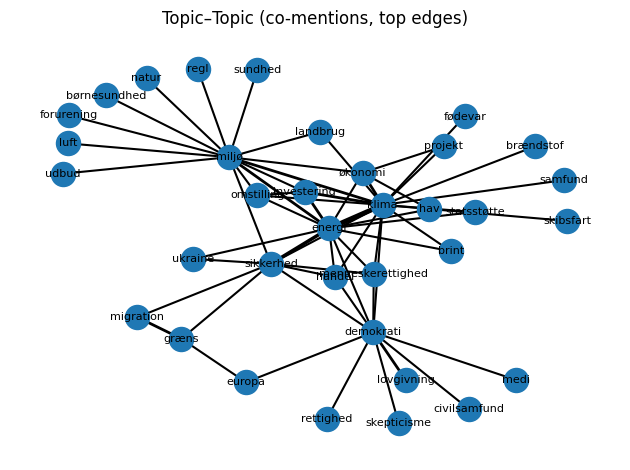

In [ ]:
# DENSIFY: Topic–Topic co-occurrence pr. tale (ingen LLM-kald)
import pandas as pd, itertools, networkx as nx, matplotlib.pyplot as plt, os, re

df = pd.read_csv("outputs/triples_normalized.csv")


STOP = {"eu", "union", "marked", "politik"}  
df = df[~df["topic"].isin(STOP)].copy()

# lav co-mentions pr. speech_id
pairs = []
for sid, grp in df.groupby("speech_id"):
    tops = sorted(set(grp["topic"]))
    for a, b in itertools.combinations(tops, 2):
        pairs.append((a, b))

print("Antal rå topic-par:", len(pairs))

if not pairs:
    print("Ingen topic-co-mentions fundet (ingen taler med ≥2 topics efter STOP-filter).")
    
    
    co = pd.DataFrame(columns=["t1", "t2", "weight"])
else:
    
    co = pd.DataFrame(pairs, columns=["t1", "t2"])
    co = co.value_counts().reset_index(name="weight")


# Build Graph
G = nx.Graph()
for _, r in co.iterrows():
    a, b, w = r["t1"], r["t2"], int(r["weight"])
    if G.has_edge(a,b):
        G[a][b]["weight"] += w
    else:
        G.add_edge(a, b, weight=w)

# centralities
deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G, weight="weight", normalized=True)
cent = pd.DataFrame({"node": list(deg.keys()),
                     "deg": [deg[n] for n in deg],
                     "betweenness": [btw[n] for n in deg]}).sort_values("deg", ascending=False)

# save
os.makedirs("outputs", exist_ok=True)
co[["t1","t2","weight"]].to_csv("outputs/edgelist_topic_topic.csv", index=False)
cent.to_csv("outputs/centrality_topicproj.csv", index=False)

# plot top edges
E = sorted(G.edges(data=True), key=lambda x: x[2].get("weight",1), reverse=True)[:60]
H = nx.Graph(); [H.add_edge(u,v,**d) for u,v,d in E]
pos = nx.spring_layout(H, seed=42)
plt.figure()
nx.draw_networkx_nodes(H, pos, node_size=300)
nx.draw_networkx_labels(H, pos, font_size=8)
nx.draw_networkx_edges(H, pos, width=[1+d.get("weight",1)*0.5 for _,_,d in H.edges(data=True)])
plt.axis("off"); plt.title("Topic–Topic (co-mentions, top edges)")
plt.tight_layout(); plt.savefig("outputs/top_topics.png", dpi=150)

print("Wrote: edgelist_topic_topic.csv, centrality_topicproj.csv, top_topics.png")



In [ ]:
print("Rows in df:", len(df))
print("Unique speeches (speech_id):", df["speech_id"].nunique())

# how many speeches have ≥2 topics after the STOP filter?
n_topics_pr_tale = df.groupby("speech_id")["topic"].nunique()
print("Speeches with ≥2 topics:", (n_topics_pr_tale >= 2).sum())

print("Number of raw topic pairs:", len(pairs))
print("Number of unique topic-topic edges in the graph:", co.shape[0])


Rækker i df: 15
Unikke taler (speech_id): 5
Taler med ≥2 topics: 5
Antal rå topic-par: 135
Antal unikke topic-topic edges i grafen: 122


## 5) Kør ved ikke hvad den skal hede

In [32]:
import pandas as pd
df_ext = pd.read_csv("outputs/triples.csv")
len(df_ext), df_ext.head(3)


(15,
              speech_id  year            speaker    party      topic
 0  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL      sport
 1  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL  arbejdere
 2  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL   diktatur)

Triples shape: (15, 5)
             speech_id  year            speaker    party      topic
0  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL      sport
1  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL  arbejdere
2  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL   diktatur
3  2013-03-13 00:00:00  2013     Anne E. Jensen     ALDE     budget
4  2013-03-13 00:00:00  2013     Anne E. Jensen     ALDE  forskning
Nodes in B: 18
Edges in B: 15
Antal topic-noder: 14
Skrev filer i outputs/: ['triples_normalized.csv', 'communities_topicproj.csv', 'top_topics.png', '_raw_llm_debug.csv', 'edgelist_topic_topic.csv', 'triples.csv', 'top_parties.png', 'manual_qa_sample.csv', 'topicproj_topedges.png', 'top_speakers.png', 'centrality_topicproj.csv', 'edgelist_bipartite.csv', 'notebook_toc.csv']


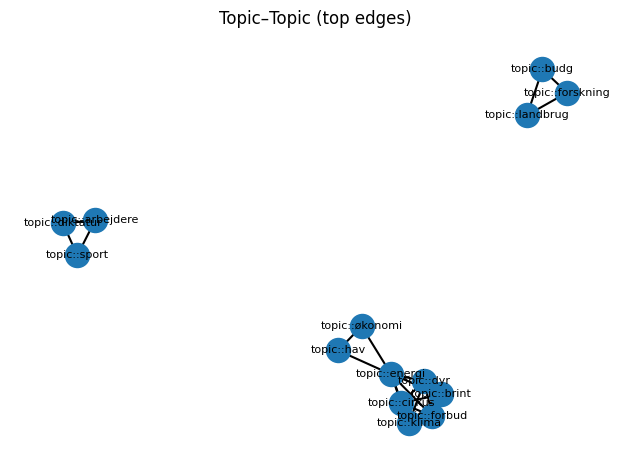

In [33]:


# --- NETVÆRK + FIGUR ---
import os, re, pandas as pd, networkx as nx, matplotlib.pyplot as plt

df = pd.read_csv("outputs/triples.csv")

print("Triples shape:", df.shape)
print(df.head())

if df.empty:
    raise ValueError(
        "outputs/triples.csv er tom – kør LLM-cellen (den med 'Primær OK ...') først, "
        "og tjek at Total rækker > 0."
    )

def norm_topic(t: str) -> str:
    t = str(t).strip().lower()
    t = re.sub(r"(erne|ende|en|et|er)$", "", t)  # meget simpel stemming
    canon = {
        "klimaforandringer":"klima", "klimaindsats":"klima",
        "arbejdspladser":"arbejde", "beskæftigelse":"arbejde",
        "indvandring":"migration", "asyl":"migration"
    }
    return canon.get(t, t)

df["topic"] = df["topic"].map(norm_topic)
df.to_csv("outputs/triples_normalized.csv", index=False)

B = nx.Graph()
for _, r in df.iterrows():
    s = f"speaker::{r['speaker']}"
    t = f"topic::{r['topic']}"
    B.add_node(s, bipartite="speaker", label=r['speaker'])
    B.add_node(t, bipartite="topic", label=r['topic'])
    B.add_edge(s, t, weight=B[s][t]["weight"] + 1 if B.has_edge(s, t) else 1)

print("Nodes in B:", B.number_of_nodes())
print("Edges in B:", B.number_of_edges())

if B.number_of_nodes() == 0:
    raise ValueError("Grafen B er tom – der er ingen gyldige speaker/topic-par at bygge på.")

topics = {n for n, d in B.nodes(data=True) if d.get("bipartite") == "topic"}
print("Antal topic-noder:", len(topics))

if not topics:
    raise ValueError(
        "Mængden 'topics' er tom – tjek at kolonnen 'topic' i triples.csv faktisk indeholder værdier."
    )

T = nx.bipartite.weighted_projected_graph(B, topics)
# ... (resten af din centralitets- og plot-kode)


T = nx.bipartite.weighted_projected_graph(B, topics)
deg = nx.degree_centrality(T)
btw = nx.betweenness_centrality(T, weight="weight", normalized=True)
pd.DataFrame({"node": list(deg.keys()),
              "deg": [deg[n] for n in deg.keys()],
              "betweenness": [btw[n] for n in deg.keys()]}) \
  .sort_values("deg", ascending=False) \
  .to_csv("outputs/centrality_topicproj.csv", index=False)

E = sorted(T.edges(data=True), key=lambda x: x[2].get("weight",1), reverse=True)[:60]
H = nx.Graph(); [H.add_edge(u,v,**d) for u,v,d in E]
pos = nx.spring_layout(H, seed=42)
plt.figure()
nx.draw_networkx_nodes(H, pos, node_size=300)
nx.draw_networkx_labels(H, pos, font_size=8)
nx.draw_networkx_edges(H, pos, width=[1+d.get("weight",1)*0.5 for _,_,d in H.edges(data=True)])
plt.axis("off"); plt.title("Topic–Topic (top edges)")
plt.tight_layout(); plt.savefig("outputs/topicproj_topedges.png", dpi=150)

print("Skrev filer i outputs/:", os.listdir("outputs"))


In [34]:
import os, pandas as pd
print(os.listdir("outputs"))
pd.read_csv("outputs/centrality_topicproj.csv").head(5)


['triples_normalized.csv', 'communities_topicproj.csv', 'top_topics.png', '_raw_llm_debug.csv', 'edgelist_topic_topic.csv', 'triples.csv', 'top_parties.png', 'manual_qa_sample.csv', 'topicproj_topedges.png', 'top_speakers.png', 'centrality_topicproj.csv', 'edgelist_bipartite.csv', 'notebook_toc.csv']


,node,deg,betweenness
0,topic::energi,0.538462,0.128205
1,topic::brint,0.384615,0.000000
2,topic::klima,0.384615,0.000000
3,topic::cirkus,0.384615,0.000000
4,topic::dyr,0.384615,0.000000


#------------------------

## 5) Normalisering (simpel, regel-baseret)

In [35]:

CANON = {
  "klimaforandringer":"klima",
  "klimaindsats":"klima",
  "arbejdsmarked":"arbejde",
  "arbejdspladser":"arbejde",
  "beskæftigelse":"arbejde",
  "indvandring":"migration",
  "asyl":"migration"
}

def norm_topic(t:str)->str:
    t = t.strip().lower()
    t = re.sub(r"(erne|ende|en|et|er)$", "", t)  # grov suffix-trim
    return CANON.get(t, t)

df_ext["topic"] = df_ext["topic"].map(norm_topic)
df_ext.to_csv("outputs/triples_normalized.csv", index=False)

counts = {
    "rows": len(df_ext),
    "speakers": df_ext["speaker"].nunique(),
    "topics": df_ext["topic"].nunique(),
    "parties": df_ext["party"].nunique()
}
counts


{'rows': 15, 'speakers': 4, 'topics': 14, 'parties': 4}

## 6) Deskriptiv udforskning + QA-sample

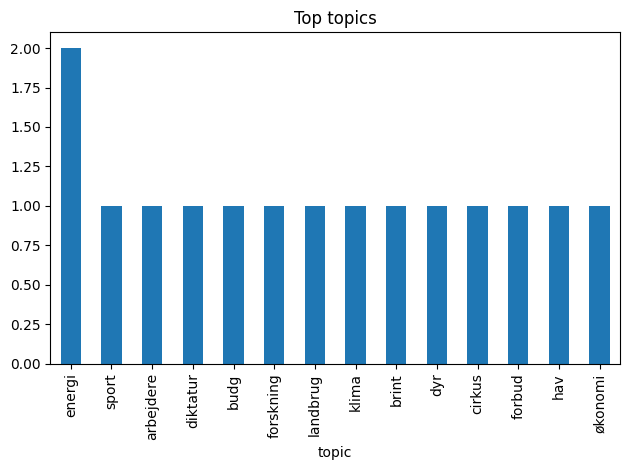

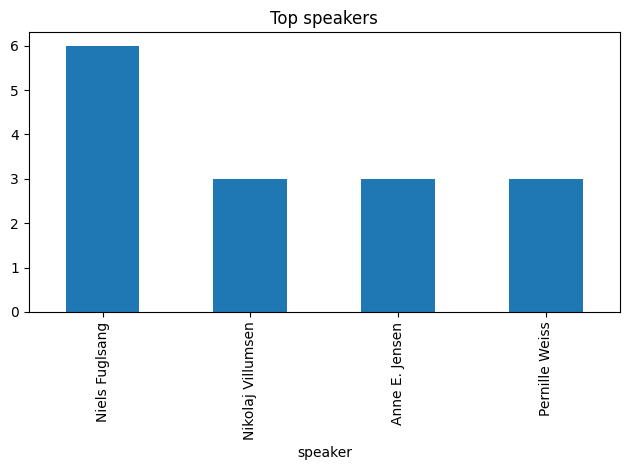

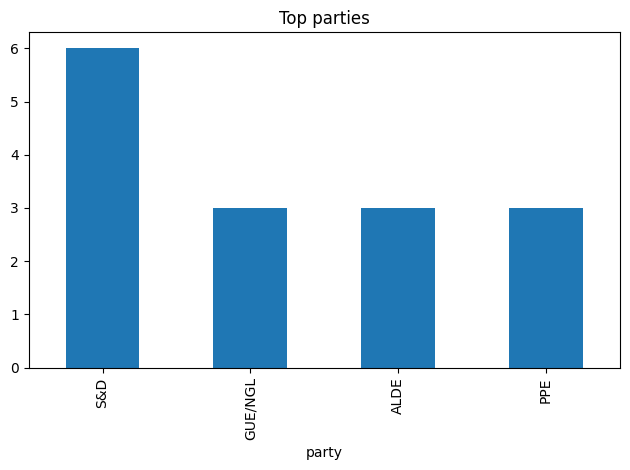

,speech_id,year,speaker,party,topic
7,2021-05-17 00:00:00,2021,Niels Fuglsang,S&D,klima
10,2021-12-16 00:00:00,2021,Niels Fuglsang,S&D,cirkus
4,2013-03-13 00:00:00,2013,Anne E. Jensen,ALDE,forskning


In [36]:

top_topics = df_ext["topic"].value_counts().head(15)
top_speakers = df_ext["speaker"].value_counts().head(15)
top_parties = df_ext["party"].value_counts(dropna=True).head(15)

plt.figure(); top_topics.plot(kind="bar", title="Top topics"); plt.tight_layout(); plt.savefig("outputs/top_topics.png"); plt.show()
plt.figure(); top_speakers.plot(kind="bar", title="Top speakers"); plt.tight_layout(); plt.savefig("outputs/top_speakers.png"); plt.show()
plt.figure(); top_parties.plot(kind="bar", title="Top parties"); plt.tight_layout(); plt.savefig("outputs/top_parties.png"); plt.show()

qa = df_ext.sample(n=min(15, len(df_ext)), random_state=123)
qa.to_csv("outputs/manual_qa_sample.csv", index=False)
qa.head(3)


## 7) Netværk: bipartit Speaker–Topic + projektion Topic–Topic

In [37]:

B = nx.Graph()
for _, r in df_ext.iterrows():
    s = f"speaker::{r['speaker']}"
    t = f"topic::{r['topic']}"
    B.add_node(s, bipartite="speaker", label=r['speaker'])
    B.add_node(t, bipartite="topic", label=r['topic'])
    if B.has_edge(s,t):
        B[s][t]["weight"] += 1
    else:
        B.add_edge(s,t, weight=1)

ed_bi = [(u,v,d["weight"]) for u,v,d in B.edges(data=True)]
pd.DataFrame(ed_bi, columns=["source","target","weight"]).to_csv("outputs/edgelist_bipartite.csv", index=False)

topics = {n for n,d in B.nodes(data=True) if d.get("bipartite")=="topic"}
T = nx.bipartite.weighted_projected_graph(B, topics)

ed_tt = [(u,v,d["weight"]) for u,v,d in T.edges(data=True)]
pd.DataFrame(ed_tt, columns=["source","target","weight"]).to_csv("outputs/edgelist_topic_topic.csv", index=False)

len(B), len(T)


(18, 14)


- **Fund:** 1–2 mest centrale topics (deg/betweenness); 2–4 communities (tematiske klynger).
- **Begrænsninger:** LLM-støj, simpel normalisering, lille QA-sample.
- **Next:** stance/sentiment som edge-attribut; tids-slices pr. år.
